# Forecasting Indonesia's Youth Unemployment Rate
with feature engineering and optimised setup

### importing libraries and data

In [289]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [290]:
df = pd.read_csv('../data_ind_youth.csv')

In [291]:
# converting to datetime format
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
# sorting order chronologically
df = df.sort_values('year_month').reset_index(drop=True)

In [292]:
df_forecast = df.copy()
# setting the time period as index
df_forecast.set_index('year_month', inplace=True)

df_forecast.index = pd.to_datetime(df_forecast.index)
df_forecast.index = pd.period_range(start=df_forecast.index[0], periods=len(df_forecast), freq='2Q')

### feature engineering and setup

In [293]:
from pycaret.time_series import *
import numpy as np

In [294]:
# feature engineering
# lag 1 = unemployment rate of the previous period
df_forecast['lag_1'] = df_forecast['Unemployment_Rate'].shift(1)
# lag 2 = unemployment rate of two periods ago
df_forecast['lag_2'] = df_forecast['Unemployment_Rate'].shift(2)
# average unemployment rate of the previous 3 periods - smooths short-term fluctuations
df_forecast['rolling_mean_3'] = df_forecast['Unemployment_Rate'].rolling(window=3, closed='left').mean()
#df_forecast['rolling_std_3'] = df_forecast['Unemployment_Rate'].rolling(window=3, closed='left').std()

df_forecast['quarter'] = df_forecast.index.quarter
# drop dows with missing values caused by shifting and rolling mean
df_forecast.dropna(inplace=True)

In [295]:
df_forecast.head()

,Unemployment_Rate,lag_1,lag_2,rolling_mean_3,quarter
2009Q3,17.142387,18.040630,18.374399,17.879705,3
2010Q1,15.775727,17.142387,18.040630,17.852472,1
2010Q3,15.989462,15.775727,17.142387,16.986248,3
2011Q1,16.851591,15.989462,15.775727,16.302525,1
2011Q3,16.717763,16.851591,15.989462,16.205593,3


In [296]:
# setup
# differences = box-cox transformation, explicitly specifying seasonal periods
exp = setup(
    data=df_forecast,
    target='Unemployment_Rate',
    fh=6,
    session_id=123,
    #transform_target='box-cox',
    seasonal_period=[2, 4]
)

,Description,Value
0,session_id,123
1,Target,Unemployment_Rate
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(31, 5)"
5,Transformed data shape,"(31, 5)"
6,Transformed train set shape,"(25, 5)"
7,Transformed test set shape,"(6, 5)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


### statistics

In [297]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,31.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,14.299465
3,Summary,Statistics,Transformed,Median,,14.186109
4,Summary,Statistics,Transformed,Standard Deviation,,1.57381
5,Summary,Statistics,Transformed,Variance,,2.476878
6,Summary,Statistics,Transformed,Kurtosis,,-1.08518
7,Summary,Statistics,Transformed,Skewness,,0.147363
8,Summary,Statistics,Transformed,# Distinct Values,,31.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",68.079361


### model comparisons

In [314]:
incl_models = pycaret_time_series_models = [
    'gbr_cds_dt',       
    'ada_cds_dt',       
    'rf_cds_dt',        
    'knn_cds_dt',       
    #'theta',           
    'dt_cds_dt',        
    #'exp_smooth',       
    #'ets',              
    #'lr_cds_dt',        
    'omp_cds_dt',       
    'ridge_cds_dt',     
    'huber_cds_dt',     
    'br_cds_dt',        
    'en_cds_dt',        
    'lasso_cds_dt',     
    'llar_cds_dt',      
    'lightgbm_cds_dt',  
    'et_cds_dt',        
    'arima',            
    #'polytrend',        
    'croston',          
    #'naive',            
    #'grand_means'       
]

In [315]:
best_model = compare_models(include=incl_models)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.8726,0.9339,1.1416,1.3724,0.0780,0.0817,-0.2018,0.0833
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.8839,0.9887,1.1541,1.4532,0.0791,0.0822,-0.2562,0.0400
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8945,0.9805,1.1792,1.4487,0.0824,0.0835,-0.2570,0.0433
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.9207,1.0103,1.2113,1.4836,0.0827,0.0869,-0.3235,0.0900
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.9207,1.0103,1.2113,1.4836,0.0827,0.0869,-0.3235,0.0433
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.9207,1.0103,1.2113,1.4836,0.0827,0.0869,-0.3235,0.0400
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9207,1.0103,1.2113,1.4836,0.0827,0.0869,-0.3235,0.0500
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.9411,1.0412,1.2028,1.5100,0.0822,0.0848,-0.3459,0.0433
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.9533,1.0171,1.2440,1.4882,0.0852,0.0896,-0.3517,0.1267
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.9810,1.0219,1.2801,1.4987,0.0880,0.0925,-0.3618,0.0733


diagnostics plot

In [258]:
exp.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

difference plot

In [259]:
exp.plot_model(
    plot="diff",
    data_kwargs={"lags_list": [[1], [1, 2]], "acf": True, "pacf": True, "periodogram": True},
    fig_kwargs={"height": 800, "width": 1500}
)

STL decomposition

In [260]:
exp.plot_model(plot="decomp_stl", fig_kwargs={"height": 500})

### fine tuning

arima

In [261]:
arima = exp.create_model('arima')
y_predict_arima = exp.predict_model(arima)
exp.plot_model(estimator=arima)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.9470,1.1278,1.5639,2.0180,0.1045,0.1092,-0.9025
1,2015Q3,0.5113,0.5118,0.6403,0.7377,0.0461,0.0455,0.4954
2,2018Q3,1.3356,1.3356,1.6097,1.8546,0.1139,0.1230,-0.7899
Mean,NaT,0.9313,0.9917,1.2713,1.5368,0.0882,0.0926,-0.3990
SD,NaT,0.3367,0.3498,0.4466,0.5690,0.0300,0.0338,0.6341


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ARIMA,0.4072,0.4681,0.4739,0.6382,0.0363,0.0359,0.5224


In [262]:
tuned_arima = tune_model(arima, n_iter=20, optimize='MASE')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.3589,1.3667,2.2442,2.4453,0.1511,0.1551,-1.7936
1,2015Q3,0.6254,0.6489,0.7832,0.9354,0.0580,0.0566,0.1886
2,2018Q3,0.6287,0.7452,0.7577,1.0347,0.0518,0.0538,0.4429
Mean,NaT,0.8710,0.9203,1.2617,1.4718,0.0870,0.0885,-0.3874
SD,NaT,0.3450,0.3181,0.6948,0.6896,0.0454,0.0471,0.9997


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.1s finished


In [263]:
exp.plot_model(estimator=tuned_arima)

In [264]:
print(arima.get_params())
print(tuned_arima.get_params())

{'concentrate_scale': False, 'enforce_invertibility': True, 'enforce_stationarity': True, 'hamilton_representation': False, 'maxiter': 50, 'measurement_error': False, 'method': 'lbfgs', 'mle_regression': True, 'order': (1, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 1, 0, 2), 'simple_differencing': False, 'start_params': None, 'suppress_warnings': False, 'time_varying_regression': False, 'trend': None, 'with_intercept': True}
{'concentrate_scale': False, 'enforce_invertibility': True, 'enforce_stationarity': True, 'hamilton_representation': False, 'maxiter': 50, 'measurement_error': False, 'method': 'lbfgs', 'mle_regression': True, 'order': (0, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 0, 0, 2), 'simple_differencing': False, 'start_params': None, 'suppress_warnings': False, 'time_varying_regression': False, 'trend': None, 'with_intercept': False}


huber regression

In [241]:
huber = exp.create_model('huber_cds_dt')
y_predict_huber = exp.predict_model(huber)
exp.plot_model(estimator=huber)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,nan,nan,nan,nan,nan,nan,nan
1,2015Q3,6.5895,6.9418,8.2528,10.0064,0.6147,0.4299,-91.8437
2,2018Q3,nan,nan,nan,nan,nan,nan,nan
Mean,NaT,nan,nan,nan,nan,nan,nan,nan
SD,NaT,nan,nan,nan,nan,nan,nan,nan


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,HuberRegressor,0,0,0,0,0,0,0


In [242]:
tuned_huber = tune_model(huber, n_iter=20, optimize='MASE', fold=2) # three folds was too much for this dataset

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2015Q3,0.5997,0.5990,0.7511,0.8634,0.0552,0.0560,0.3088
1,2018Q3,1.0154,1.1492,1.2238,1.5957,0.0830,0.0892,-0.3251
Mean,NaT,0.8076,0.8741,0.9874,1.2296,0.0691,0.0726,-0.0081
SD,NaT,0.2079,0.2751,0.2364,0.3662,0.0139,0.0166,0.3169


Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.0s finished


In [243]:
exp.plot_model(estimator=tuned_huber)

In [244]:
print(huber.get_params())
print(tuned_huber.get_params())

{'degree': 1, 'deseasonal_model': 'additive', 'fe_target_rr': [WindowSummarizer(lag_feature={'lag': [2, 1]}, n_jobs=1)], 'regressor': HuberRegressor(), 'sp': 2, 'window_length': 2, 'regressor__alpha': 0.0001, 'regressor__epsilon': 1.35, 'regressor__fit_intercept': True, 'regressor__max_iter': 100, 'regressor__tol': 1e-05, 'regressor__warm_start': False}
{'degree': 1, 'deseasonal_model': 'additive', 'fe_target_rr': [WindowSummarizer(lag_feature={'lag': [2, 1]}, n_jobs=1)], 'regressor': HuberRegressor(), 'sp': 2, 'window_length': 2, 'regressor__alpha': 0.0001, 'regressor__epsilon': 1.35, 'regressor__fit_intercept': True, 'regressor__max_iter': 100, 'regressor__tol': 1e-05, 'regressor__warm_start': False}


comparisons

In [245]:
exp.compare_models(include=[arima, tuned_arima, huber, tuned_huber], sort='MASE')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
1,ARIMA,0.9955,1.0279,1.4158,1.6276,0.0999,0.0996,-0.6598,0.0467
0,ARIMA,1.1441,1.2163,1.5487,1.8764,0.1098,0.1172,-1.0881,0.0433


ARIMA(seasonal_order=(1, 1, 0, 2), with_intercept=False)

In [246]:
exp.plot_model([arima, tuned_arima, huber, tuned_huber], data_kwargs={"labels": ["arima", "tuned_arima", "huber", "tuned_huber"]})

### finalise model and future forecast

In [247]:
final_model = exp.finalize_model(tuned_arima)

In [168]:
# future periods to predict
future_periods = pd.period_range(start=df_forecast.index[-1] + 1, periods=6, freq='2Q')  # 5 future periods

# initialising future_df with NaNs for features and target
future_df = pd.DataFrame(index=future_periods, columns=['Unemployment_Rate', 'lag_1', 'lag_2', 'rolling_mean_3'])
future_df[['Unemployment_Rate', 'lag_1', 'lag_2', 'rolling_mean_3']] = np.nan

In [169]:
# defining a function to get value from historical or predicted data
def get_value_for_period(period):
    if period in df_forecast.index:
        return df_forecast.loc[period, 'Unemployment_Rate']
    elif period in future_df.index and not pd.isna(future_df.loc[period, 'Unemployment_Rate']):
        return future_df.loc[period, 'Unemployment_Rate']
    else:
        return np.nan

In [ ]:
# looping over each future period and predict
for period in future_periods:
    # calculating the lag features
    lag_1 = get_value_for_period(period - 1)
    lag_2 = get_value_for_period(period - 2)

    # rolling mean of last 3 values (lags 1, 2, 3)
    last_three_vals = [get_value_for_period(period - i) for i in range(1, 4)]
    rolling_mean_3 = np.nanmean(last_three_vals)  # np.nanmean ignores nan values

    # saving features into future_df
    future_df.loc[period, ['lag_1', 'lag_2', 'rolling_mean_3']] = [lag_1, lag_2, rolling_mean_3]

    # preparing feature vector for prediction
    X_pred = future_df.loc[[period], ['lag_1', 'lag_2', 'rolling_mean_3']].astype(float)

    # checking for NaNs before predicting
    if X_pred.isnull().values.any():
        raise ValueError(f"NaN found in features at period {period}:\n{X_pred}")

    # forecasting future values
    pred_df = predict_model(final_model, X=X_pred, fh=[1])
    pred_value = pred_df['y_pred'].values[0]

    # saving predicted value back to future_df for next iterations
    future_df.loc[period, 'Unemployment_Rate'] = pred_value

    print(f"Predicted Unemployment_Rate at {period}: {pred_value:.3f}")

Predicted Unemployment_Rate at 2025Q1: 11.593
Predicted Unemployment_Rate at 2025Q3: 10.951
Predicted Unemployment_Rate at 2026Q1: 11.187
Predicted Unemployment_Rate at 2026Q3: 11.512
Predicted Unemployment_Rate at 2027Q1: 11.543
Predicted Unemployment_Rate at 2027Q3: 11.431


In [175]:
# concatenating historical and future predictions into one DataFrame
combined_df = pd.concat([df_forecast[['Unemployment_Rate']], future_df[['Unemployment_Rate']]], axis=0)

# creating a column to indicate whether the value is historical or predicted
combined_df['Type'] = ['Historical'] * len(df_forecast) + ['Predicted'] * len(future_df)

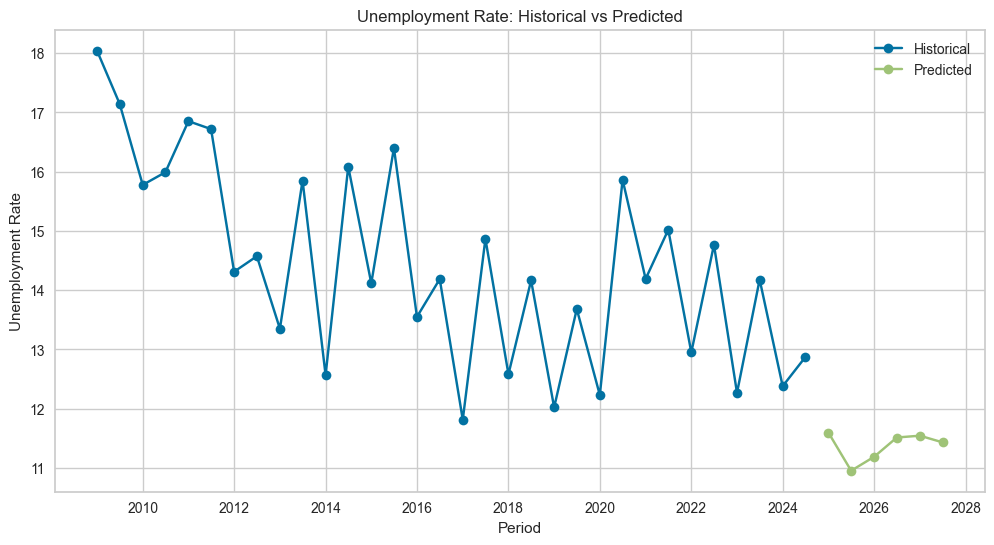

In [176]:
# plotting
plt.figure(figsize=(12,6))

for t_type, group_data in combined_df.groupby('Type'):
    plt.plot(group_data.index.to_timestamp(), group_data['Unemployment_Rate'], 
             marker='o', label=t_type)

plt.title('Unemployment Rate: Historical vs Predicted')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.show()

In [177]:
future_df

,Unemployment_Rate,lag_1,lag_2,rolling_mean_3
2025Q1,11.5930,12.871909,12.378460,12.625185
2025Q3,10.9513,11.593000,12.871909,12.232455
2026Q1,11.1871,10.951300,11.593000,11.272150
2026Q3,11.5120,11.187100,10.951300,11.069200
2027Q1,11.5426,11.512000,11.187100,11.349550
2027Q3,11.4306,11.542600,11.512000,11.527300
